In [14]:
%matplotlib inline

!gammapy info --no-envvar --no-system
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.convolution import Gaussian2DKernel
from regions import CircleSkyRegion
from gammapy.utils.energy import EnergyBounds
from gammapy.utils.fitting import Fit
from gammapy.data import DataStore
from gammapy.data.data_store import CalDBIRF
from gammapy.spectrum import (
    SpectrumExtraction,
    models,
    FluxPointsEstimator,
    FluxPointsDataset,
)
from gammapy.maps import MapAxis, WcsNDMap, WcsGeom
from gammapy.cube import MapMaker
from gammapy.background import ReflectedRegionsBackgroundEstimator
from gammapy.detect import TSMapEstimator, find_peaks



Gammapy package:

	path                   : /photon1/users/labsaha/miniconda/envs/gammapy-0.12/lib/python3.6/site-packages/gammapy 
	version                : 0.12       


Other packages:

	numpy                  : 1.16.4     
	scipy                  : 1.2.1      
	matplotlib             : 2.2.3      
	cython                 : not installed 
	astropy                : 3.0.4      
	astropy_healpix        : 0.4        
	reproject              : 0.4        
	sherpa                 : 4.11.0     
	pytest                 : 4.6.3      
	sphinx                 : not installed 
	healpy                 : 1.11.0     
	regions                : 0.3        
	iminuit                : 1.3.7      
	naima                  : 0.8.3      
	uncertainties          : 3.0.3      



In [2]:
# Configure the logger, so that the spectral analysis
# isn't so chatty about what it's doing.
import logging

logging.basicConfig()
log = logging.getLogger("gammapy.spectrum")
log.setLevel(logging.ERROR)

In [105]:
#import os
#os.environ['CTADATA'] = ''
#!echo $CTADATA
#!ls $CTADATA

In [ ]:
data_store = DataStore.from_dir("$CTADATA/index/gps")
#data_store1 = DataStore.from_dir("$CTADATA/data/gps")

In [ ]:
data_store.info()

In [ ]:
obs_id = [110380, 111140, 111159]

In [ ]:
obs_list = data_store?

In [ ]:
obs_list = data_store

In [ ]:
obs_id = [110380, 111140, 111159]

#data_store.obs_table.rename_column('TSTART', 'START')
observations = data_store.get_observations()

In [73]:
from gammapy.data import DataStore
#path = "/photon1/users/labsaha/gammapy_analysis/data/1dc/data/baseline/gps/gps_baseline_110380.fits"
path = "/photon1/users/labsaha/gammapy_analysis/gammapy_analysis/crab/crab.fits"
data_store = DataStore.from_events_files([path])
observations = data_store.get_observations()


In [74]:
print(observations)

Observations
Number of observations: 1
Info for OBS_ID = 1
- Start time: 58849.00
- Pointing pos: RA 83.63 deg / Dec 22.51 deg
- Observation duration: 259200.0 s
- Dead-time fraction: 2.000 %



In [75]:
#obs_cols = ["OBS_ID", "GLON_PNT", "GLAT_PNT", "LIVETIME"]
#data_store.obs_table.select_obs_id(obs_id)[obs_cols]

In [76]:
axis = MapAxis.from_edges(
    np.logspace(-1.0, 1.0, 10), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(184.55745, -05.78436), npix=(500, 400), binsz=0.02, coordsys="GAL", axes=[axis]
)
geom

WcsGeom

	axes       : lon, lat, energy
	shape      : (500, 400, 9)
	ndim       : 3
	coordsys   : GAL
	projection : CAR
	center     : 184.6 deg, -5.8 deg
	width      : 10.0 deg x 8.0 deg

In [77]:
target_position = SkyCoord(184.55745, -05.78436, unit="deg", frame="galactic")
on_radius = 0.2 * u.deg
on_region = CircleSkyRegion(center=target_position, radius=on_radius)

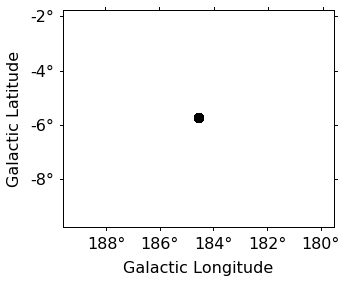

In [78]:
exclusion_mask = geom.to_image().region_mask([on_region], inside=False)
exclusion_mask = WcsNDMap(geom.to_image(), exclusion_mask)
exclusion_mask.plot();

In [79]:
%%time
maker = MapMaker(geom, offset_max="3 deg")

CPU times: user 297 µs, sys: 99 µs, total: 396 µs
Wall time: 407 µs


In [80]:
import os
os.environ['CALDB'] = '/photon1/users/labsaha/gammapy_analysis/data/1dc/'
maps=maker.run(observations)
print(maps.keys())

dict_keys(['counts', 'exposure', 'background'])


In [81]:
images = maker.run_images()

excess = images["counts"].copy()
excess.data -= images["background"].data
images["excess"] = excess

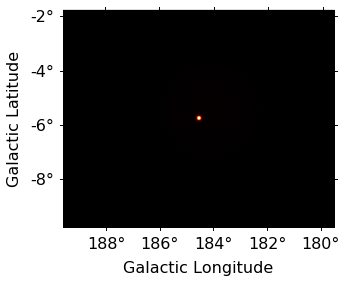

In [82]:
images["counts"].plot();

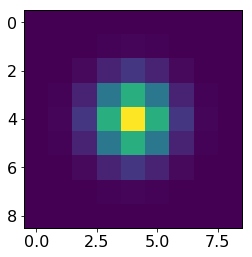

In [83]:
kernel = Gaussian2DKernel(1, mode="oversample").array
plt.imshow(kernel);

In [84]:
%%time
ts_image_estimator = TSMapEstimator()
images_ts = ts_image_estimator.run(images, kernel)
print(images_ts.keys())

dict_keys(['ts', 'sqrt_ts', 'flux', 'flux_err', 'flux_ul', 'niter'])
CPU times: user 478 ms, sys: 57.7 ms, total: 536 ms
Wall time: 5.96 s


CPU times: user 39.7 s, sys: 12.9 s, total: 52.6 s
Wall time: 52.6 s


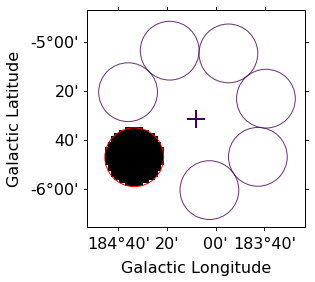

In [85]:
%%time
bkg_estimator = ReflectedRegionsBackgroundEstimator(
    observations=observations,
    on_region=on_region,
    exclusion_mask=exclusion_mask,
)
bkg_estimator.run()
bkg_estimate = bkg_estimator.result
bkg_estimator.plot();

In [86]:
%%time
extract = SpectrumExtraction(
    observations=observations, bkg_estimate=bkg_estimate
)
extract.run()


No thresholds defined for obs Info for OBS_ID = 1
- Start time: 58849.00
- Pointing pos: RA 83.63 deg / Dec 22.51 deg
- Observation duration: 259200.0 s
- Dead-time fraction: 2.000 %



CPU times: user 328 ms, sys: 1.74 ms, total: 329 ms
Wall time: 328 ms


In [87]:
model = models.PowerLaw(
    index=2, amplitude=1e-11 * u.Unit("cm-2 s-1 TeV-1"), reference=1 * u.TeV
)

for dataset in extract.spectrum_observations:
    dataset.model = model

fit = Fit(extract.spectrum_observations)
result = fit.run()
print(result)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 81
	total stat : 122242.38



In [88]:
# Flux points are computed on stacked observation
from gammapy.spectrum import SpectrumDatasetOnOffStacker

stacker = SpectrumDatasetOnOffStacker(extract.spectrum_observations)
stacked_obs = stacker.run()

print(stacked_obs)

In [96]:
ebounds = EnergyBounds.equal_log_spacing(.1, 40, 3, unit=u.TeV)

stacked_obs.model = model

fpe = FluxPointsEstimator(datasets=[dataset], e_edges=ebounds)
flux_points = fpe.run()
flux_points.table_formatted

e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,ref_e2dnde,norm,loglike,norm_err,counts [1],norm_errp,norm_errn,norm_ul,sqrt_ts,ts,norm_scan [11],dloglike_scan [11],dnde,dnde_ul,dnde_err,dnde_errp,dnde_errn
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.278,0.100,0.774,6.836e-10,5.201e-10,1.103e-10,5.293e-11,1.135,602.233,0.002,419049,0.002,0.002,1.138,987.589,975332.905,0.200 .. 5.000,520233.82905505795 .. 1452980.8577390364,7.756e-10,7.782e-10,1.298e-12,1.298e-12,1.297e-12
2.021,0.774,5.275,6.800e-12,3.407e-11,5.416e-11,2.777e-11,0.923,3790.778,0.003,110197,0.003,0.003,0.929,585.558,342877.868,0.200 .. 5.000,148118.5969670458 .. 586715.9612439191,6.277e-12,6.316e-12,1.939e-14,1.925e-14,1.952e-14
14.678,5.275,40.842,6.765e-14,2.715e-12,3.038e-11,1.457e-11,0.592,177.596,0.005,15026,0.005,0.005,0.602,223.525,49963.407,0.200 .. 5.000,12151.104011555792 .. 156921.89652202468,4.004e-14,4.071e-14,3.320e-16,3.336e-16,3.304e-16


In [97]:
model.parameters.covariance = result.parameters.covariance
flux_points_dataset = FluxPointsDataset(data=flux_points, model=model)

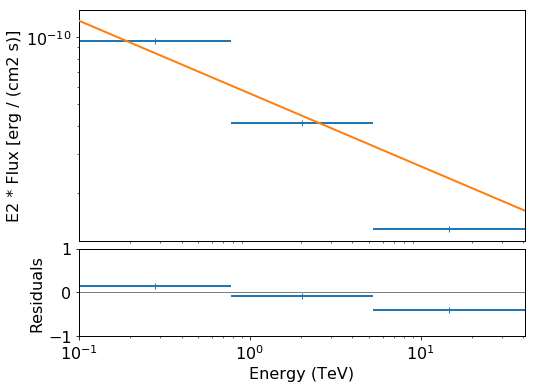

In [98]:
plt.figure(figsize=(8, 6))
flux_points_dataset.peek();

5.200000000000001e-18 1 / (cm2 MeV s)


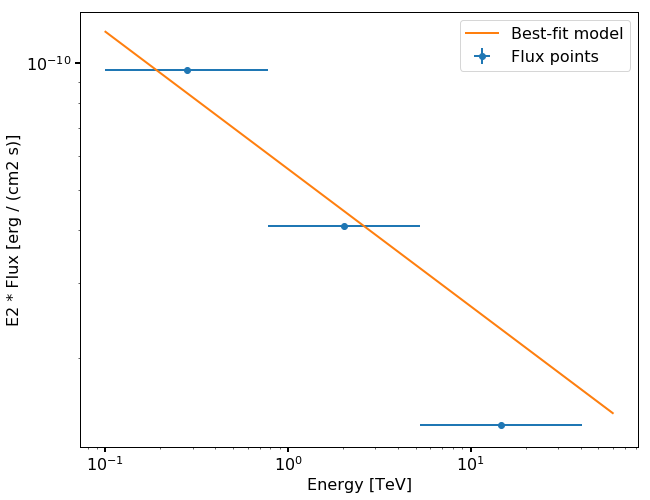

In [104]:
plt.figure(figsize=(10,8))
flux_points.plot(marker='o',label='Flux points',energy_power=2,flux_unit='erg-1 cm-2 s-1')
#fpe.flux_points.ploterror()
#model = fit.result[0].model

import matplotlib as mpl
mpl.rcParams['lines.linewidth']=2
mpl.rcParams['axes.linewidth']=1.0
mpl.rcParams['font.size']=16

model_org = models.PowerLaw(
    index=2.4 * u.Unit(''),
    amplitude=5.2*1e-18 * u.Unit('cm-2 s-1 MeV-1'),
    reference=1.0e6 * u.MeV
)
energy_range = [0.1, 60] * u.TeV
#model_org.plot(energy_range, energy_power=2,label='True model before correction',flux_unit='erg-1 cm-2 s-1')
model.plot(energy_range, energy_power=2,label='Best-fit model',flux_unit='erg-1 cm-2 s-1')
model.plot_error(energy_range, energy_power=2,flux_unit='erg-1 cm-2 s-1')
#plt.ylim(5e-14,1e-11)
plt.legend(fontsize=16)
plt.tick_params(labelsize=16)
plt.tick_params(size=5,width=2)
print(model_org(1.0e6*u.MeV))